In [1]:
from metadensity.metadensity import *
from metadensity.plotd import *
from metadensity.pos_enrich import *
import pandas as pd
import matplotlib.pyplot as plt

Using:  /home/hsher/gencode_coords/gencode.v33.transcript.gff3


# Load encode metadata
I have precompiled list of uID and the .bam, .bigWig files in the following dataframe.

In [2]:
# load IDs
encode_data = pd.read_pickle('~/projects/eclip_encode_id.pickle')
eclip_bam = pd.read_csv('/home/hsher/projects/RBP_annot/ENCODE_FINAL_ANNOTATIONS.uidsonly.txt.manifesthg38.txt', sep = '\t', header= 0)

# join data
encode_data = pd.merge(eclip_bam[['uID', 'RBP', 'Cell line']], encode_data, left_on = ['RBP', 'Cell line'], right_on = ['RBP', 'cell_line'])

cols = [e for e in encode_data.columns if 'bam' in e or 'minus' in e or 'plus' in e]
bam_basedir = '/home/hsher/seqdata/eclip_raw/'
import os
for c in cols:
    encode_data[c] = bam_basedir+encode_data[c]
encode_data['idr'] = '/home/hsher/seqdata/eclip_bed/sorted/'+encode_data['uID']+'.01v02.IDR.out.0102merged.bed.blacklist_removed.bed.narrowPeak.bed'
for row in encode_data.index:
    uid = encode_data.loc[row, 'uID']
    encode_data['bed_0'] = '/home/elvannostrand/data/clip/CLIPseq_analysis/ENCODE_FINALforpapers_20180205/hg38/' + '{0}_0{1}.basedon_{0}_0{1}.peaks.l2inputnormnew.bed.compressed.bed.blacklist_removed.bed'.format(uid, 1)
    encode_data['bed_1'] = '/home/elvannostrand/data/clip/CLIPseq_analysis/ENCODE_FINALforpapers_20180205/hg38/' + '{0}_0{1}.basedon_{0}_0{1}.peaks.l2inputnormnew.bed.compressed.bed.blacklist_removed.bed'.format(uid, 2)
encode_data['uid'] = encode_data['uID']

In [3]:
encode4 = pd.read_csv('/home/hsher/projects/ClipNet/archishma/ENCODE4_1214.csv')

# load RBPs into eCLIP object

I build an eCLIP object that will connect all .bam, .bigWig and .bed (for IDR peaks, individual peaks) together. All you need to do is point a row of the previous dataframe, and use `RBP_centric_approach()` to compute the regions for metagene, and find positive (transcripts with IDR) and negative (transcript w/o any peaks) examples. Building the object will take a while (~1 min) since a lot of I/O.

In [4]:
s = encode_data.loc[(encode_data['RBP'] == 'U2AF1')&(encode_data['Cell line'] == 'HepG2')].iloc[0]
U2AF1= eCLIP.from_series(s, single_end = False)

In [5]:
s = encode_data.loc[(encode_data['RBP'] == 'RBM22')&(encode_data['Cell line'] == 'HepG2')].iloc[0]
RBM22= eCLIP.from_series(s, single_end = False)

In [6]:
s = encode4.loc[(encode4['RBP'] == 'EIF4E')&(encode4['Cell Line'] == 'HepG2')].iloc[0]
EIF4E= eCLIP.from_series(s, single_end = True)

# Construct metagene using BioGPS highly expressed genes
We advise using highly expressed genes (cell line specific) as the transcripts used to construct the metagene

In [7]:
cds_metagenes = highly_exp_biogps(cell_line = 'HEPG2',sample_no = 150)

/home/hsher/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Using: /home/hsher/miniconda3/lib/python3.7/site-packages/metadensity-0.0.1-py3.7.egg/metadensity/data/hg38/gencode
Done building metagene


# Positional Enrichment Analysis is done by comparing the null (input) density to the real (IP) density.

Use Wilcoxon sum rank test to see which position has sigificant difference

In [8]:
# construct null distribution for everyone :)
eclips = [U2AF1, RBM22, EIF4E]
all_metaden_null = {}
all_metaden = {}
for e in eclips:
    m_null, m_ip = construct_distribution(e, cds_metagenes)
    
    all_metaden_null[e.name] = m_null
    all_metaden[e.name] = m_ip
    print('Done with {}'.format(e.name))


/home/hsher/miniconda3/lib/python3.7/site-packages/metadensity-0.0.1-py3.7.egg/metadensity/metadensity.py:625: RuntimeWarning: invalid value encountered in true_divide
  values = values/np.sum(values)
/home/hsher/miniconda3/lib/python3.7/site-packages/metadensity-0.0.1-py3.7.egg/metadensity/metadensity.py:566: RuntimeWarning: Mean of empty slice
  feature_average  = np.nanmean(np.stack(all_feature_values), axis = 0)


Done constructing an empirical null distribution from Input
Done constructing IP distribution
Done with U2AF1
Done constructing an empirical null distribution from Input
Done constructing IP distribution
Done with RBM22
Done constructing an empirical null distribution from Input
Done constructing IP distribution
Done with EIF4E


## Get test statistics and p-value

In [9]:
wilcox_results = {} # test statistics
pval_results = {} # unadjusted p-value
for rbp in all_metaden.keys():
    wilcox_results[rbp], pval_results[rbp] = Wilcox_enrich(all_metaden_null[rbp], all_metaden[rbp],  n_largest_to_remove = 15)

/home/hsher/miniconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [10]:
def plot_auc_result(result, ylabel='Wilcox', smooth = True, features_to_show=['first_exon', 'exon','intron', 'last_exon'], ymax = 3000):
    ''' feed any enrichment results into her'''
    f,ax = generate_axis(nrows=1,features_to_show = features_to_show)
    for rbp in result.keys():
        for key in ax.keys():
            feat = key[0]
            align = key[1]
            
            if smooth:
                ax[key].plot(gaussian_smooth(result[rbp][key]), label = rbp)
                
            else:
                ax[key].plot(result[rbp][key], label = rbp)
            if feat == 'first_exon' and align =='left':
                ax[key].set_ylabel(ylabel)
        ax[key].legend()
        ax[key].set_ylim([0,ymax])

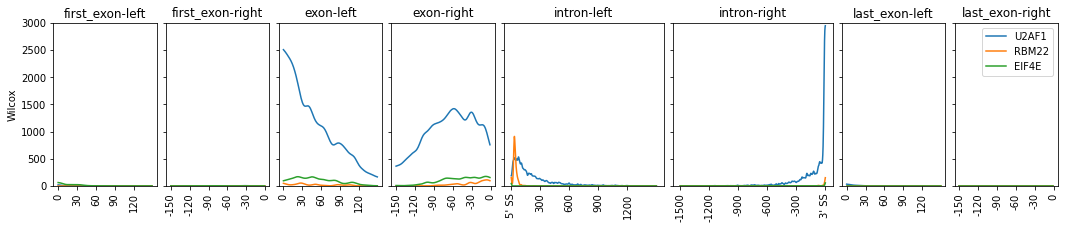

In [11]:
plot_auc_result(wilcox_results)

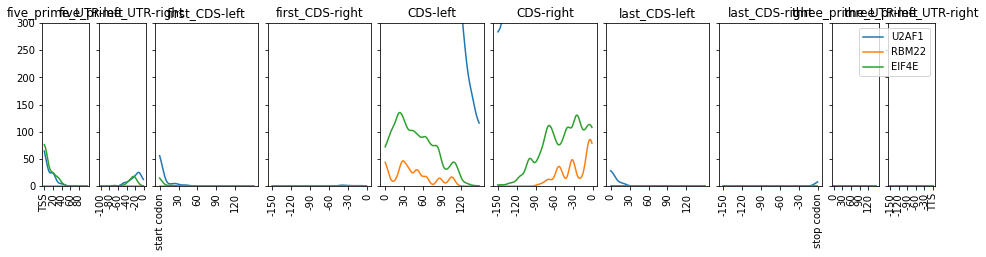

In [12]:
plot_auc_result(wilcox_results, features_to_show = ['five_prime_UTR', 'first_CDS', 'CDS', 'last_CDS', 'three_prime_UTR'], ymax = 300)